In [3]:
import os
import pandas as pd
from pymongo import MongoClient
from typing import List
import sys
MONGO_URI = os.getenv("MONGO_URI", "mongodb://localhost:27017/")
DB_NAME = os.getenv("DB_NAME", "amazon_reviews")
COLLECTION_NAME = os.getenv("COLLECTION_NAME", "reviews")
DATA_FILE = os.path.join("data", "Reviews.csv")
SAMPLE_SIZE = 10000  # Limit initial load to 10k rows for speed
# Using a sample because the file is huge!
client = MongoClient(MONGO_URI)
db = client[DB_NAME]
collection = db[COLLECTION_NAME]
cursor = collection.find().limit(50000)

#converting the cursor to a list of dictionaries, then to a DataFrame
df = pd.DataFrame(list(cursor))

#removing the _id column that was added from mongodb
if not df.empty and '_id' in df.columns:
    df = df.drop(columns=['_id'])


print(f"Data loaded successfully from MongoDB! Total rows: {len(df)}")

Data loaded successfully from MongoDB! Total rows: 50000


In [4]:
print(df.head())

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [5]:
print(df.isna().sum())
print(df.duplicated().sum())
# only small number of nulls in not important features: ProfileName, (summary is important) and no duplicates

Id                        0
ProductId                 0
UserId                    0
ProfileName               5
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   2
Text                      0
dtype: int64
0


In [6]:
#droping rows that have null summmary

df = df.dropna(subset=['Summary'])
print(df.isna().sum())

Id                        0
ProductId                 0
UserId                    0
ProfileName               5
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64


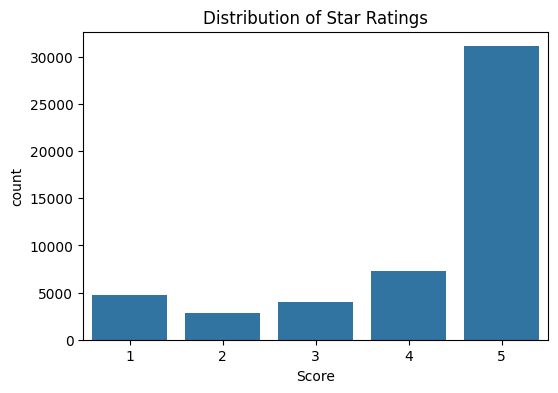

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='Score', data=df)
plt.title('Distribution of Star Ratings')
plt.show()


In [10]:
#After finding that the number of five star reviews is much larger than the number of one/two/three/four star reviews, We decided to do
# down sampling to avoid model prediction laziness (1(positive review)) and get a good accuracy.

# Separate the classes, removing the reviews of score 3 as they are neutral (have both good and bad words togther)

df = df[df['Score'] != 3]

df['Sentiment'] = df['Score'].apply(lambda x: 1 if x >= 4 else 0)

min_size = df['Sentiment'].value_counts().min()

df_pos = df[df['Sentiment'] == 1].sample(n=min_size, random_state=42)
df_neg = df[df['Sentiment'] == 0].sample(n=min_size, random_state=42)

balanced_df = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=42)

print("Balanced Sentiment Distribution:")
print(balanced_df['Sentiment'].value_counts())

Balanced Sentiment Distribution:
0    7533
1    7533
Name: Sentiment, dtype: int64


In [11]:
balanced_df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
48272,48273,B004SRH2B6,ACE2UV64BSIM0,bbrown,1,1,1,1343606400,Really bad taste : (,I was expecting this to taste as good as some ...,0
46383,46384,B002GJ9JWS,AJZWI84XRI4OS,Frantastic,0,0,5,1349654400,Love this stuff!,Can't go wrong with this product. I have no co...,1
9027,9028,B006N3IG4K,A1PGA8C2EAUSBT,funlinesdirect,2,3,2,1287446400,Great name but I didn't care for it,I drink about 4 to 6 cups of coffee every morn...,0
39432,39433,B001ELL86Y,A17V0GPCRIXRF7,Marc R Recasino,2,2,1,1317340800,k-cup package,The coffee package leeks out all over machine ...,0
49025,49026,B007S0FZY6,A2FP1XVV2QTOCO,gumguy6667,1,1,2,1337126400,Fruity fresh? More like Fruity LAME,"<span class=""tiny""> Length:: 1:02 Mins<br /><b...",0
...,...,...,...,...,...,...,...,...,...,...,...
27905,27906,B0015G862M,AJV2QY96IVPVM,SuperFids,0,0,5,1247443200,Great product for traveling with your dog!,"My dog is on a raw diet, which makes travel so...",1
35065,35066,B002DLXXHG,A2AXRD9IOU4UIH,"bargainhunter ""amazingbargains""",2,3,1,1270425600,Must be your first time trying jerky if you le...,Let me say this first: our family of 6 keeps ...,0
24924,24925,B0078Y6OX8,AL7N0L8AI7NH3,Pete,0,0,5,1288742400,Best Flavor - Super Convenient,"Of all the K-Cup flavors we've brewed, this is...",1
29572,29573,B000PDY3P0,A3KTVXSMCWP0XQ,Harv Walton,0,1,4,1240617600,Easy popcorn,I'm happy to say that in this case a pretty pa...,1


C:\Users\ahmed\AppData\Local\Temp\ipykernel_3180\4287812407.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Score', data=df, ax=ax[0], palette='Reds_r')
C:\Users\ahmed\AppData\Local\Temp\ipykernel_3180\4287812407.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=balanced_df, ax=ax[1], palette='Blues')


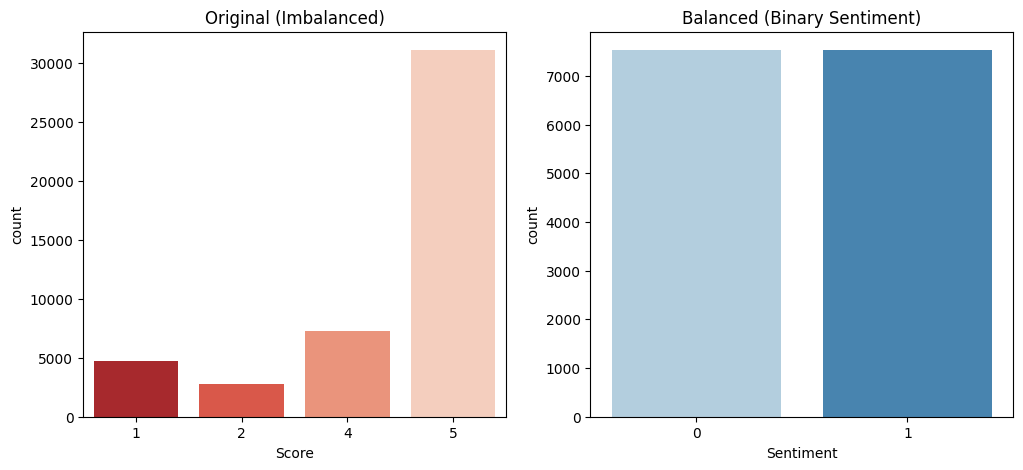

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Before
sns.countplot(x='Score', data=df, ax=ax[0], palette='Reds_r')
ax[0].set_title('Original (Imbalanced)')

# After
sns.countplot(x='Sentiment', data=balanced_df, ax=ax[1], palette='Blues')
ax[1].set_title('Balanced (Binary Sentiment)')

plt.show()

In [13]:
# for our dataset, it is not a good practice to use features like Id, ProductId, UserId, ProfileName, , Time as they are not something that a user enters
# and for example the same user can do both positive and negative reviews
# Also HelpfulnessNumerator,	HelpfulnessDenominator can't be an indicator of positive or negative review
# But Summary and text features are good indicators for a positive or negative review, as summary can be concise and text are more detailed.
# So we decided to drop Id, ProductId, UserId, ProfileName, , Time, HelpfulnessNumerator,	HelpfulnessDenominator and combine summary and text features

balanced_df['Combined_Content'] = balanced_df['Summary'] + " " + balanced_df['Text']

final_balanced_df = balanced_df[['Combined_Content', 'Sentiment']].copy()

print("Columns remaining:", final_balanced_df.columns.tolist())
print(final_balanced_df.head())



Columns remaining: ['Combined_Content', 'Sentiment']
                                        Combined_Content  Sentiment
48272  Really bad taste  : ( I was expecting this to ...          0
46383  Love this stuff! Can't go wrong with this prod...          1
9027   Great name but I didn't care for it I drink ab...          0
39432  k-cup package The coffee package leeks out all...          0
49025  Fruity fresh?  More like Fruity LAME <span cla...          0


In [14]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# removing the links, doing lowercase, and removing the stopwords
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    words = text.split()
    words = [w for w in words if w not in stop_words]

    return " ".join(words)

final_balanced_df['Cleaned_content'] = final_balanced_df['Combined_Content'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [15]:
print(final_balanced_df[['Cleaned_content','Sentiment']])

                                         Cleaned_content  Sentiment
48272  really bad taste expecting taste good coconut ...          0
46383  love stuff go wrong product complaints helps p...          1
9027   great name care drink cups coffee every mornin...          0
39432  k cup package coffee package leeks machine wia...          0
49025          fruity fresh like fruity lame length mins          0
...                                                  ...        ...
27905  great product traveling dog dog raw diet makes...          1
35065  must first time trying jerky left good review ...          0
24924  best flavor super convenient k cup flavors bre...          1
29572  easy popcorn happy say case pretty package equ...          1
24695  dog favorite treat dog loves sweet potatoes sw...          1

[15066 rows x 2 columns]


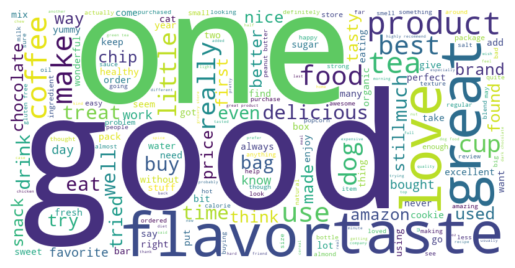

In [20]:
from wordcloud import WordCloud

#combine all text shown in the positive reviews
positive_text = " ".join(final_balanced_df[final_balanced_df['Sentiment'] == 1]['Cleaned_content'])

# Generate cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_image = wordcloud.to_image()

# Now plot the image object instead of the wordcloud object
plt.imshow(wordcloud_image, interpolation='bilinear')
plt.axis("off")
plt.show()


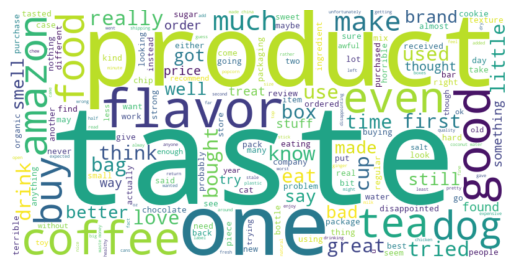

In [21]:

# combine all texts shown in the negative reviews
negative_text = " ".join(final_balanced_df[final_balanced_df['Sentiment'] == 0]['Cleaned_content'])

# Generate cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

wordcloud_image = wordcloud.to_image()

# Now plot the image object instead of the wordcloud object
plt.imshow(wordcloud_image, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()


def apply_lemmatization(text):
    words = text.split()
    lemmatized = [lemmatizer.lemmatize(w, pos='v') for w in words]

    return " ".join(lemmatized)

final_balanced_df['Cleaned_content'] = final_balanced_df['Cleaned_content'].apply(apply_lemmatization)
print(final_balanced_df['Cleaned_content'].head())

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


48272    really bad taste expect taste good coconut wat...
46383    love stuff go wrong product complaints help pe...
9027     great name care drink cup coffee every morning...
39432    k cup package coffee package leeks machine wia...
49025            fruity fresh like fruity lame length mins
Name: Cleaned_content, dtype: object


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))


X = tfidf.fit_transform(final_balanced_df['Cleaned_content'])

y = final_balanced_df['Sentiment']

print(f"Vectorization complete! Matrix shape: {X.shape}")

Vectorization complete! Matrix shape: (15066, 10000)


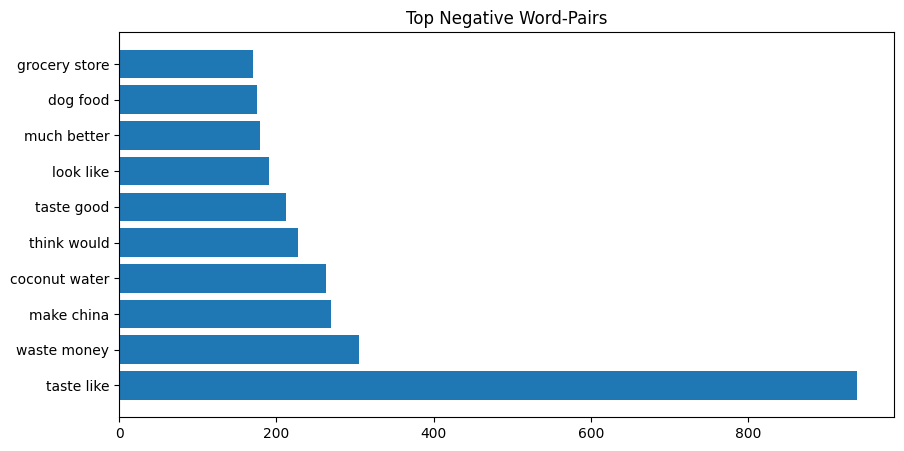

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams(text, title, n=2):
    vec = CountVectorizer(ngram_range=(n, n)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:10]

    words, counts = zip(*words_freq)
    plt.barh(words, counts)
    plt.title(title)

plt.figure(figsize=(10,5))
plot_top_ngrams(final_balanced_df[final_balanced_df['Sentiment']==0]['Cleaned_content'], "Top Negative Word-Pairs")
plt.show()

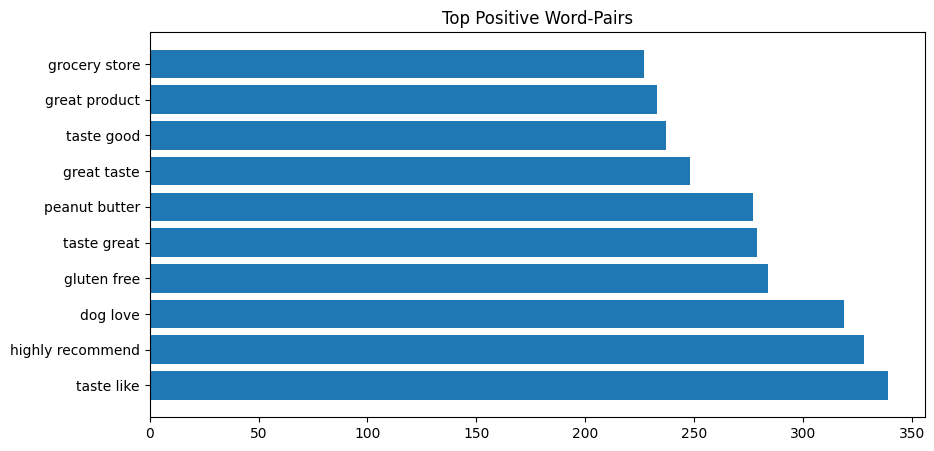

In [26]:

plt.figure(figsize=(10,5))
plot_top_ngrams(final_balanced_df[final_balanced_df['Sentiment']==1]['Cleaned_content'], "Top Positive Word-Pairs")
plt.show()

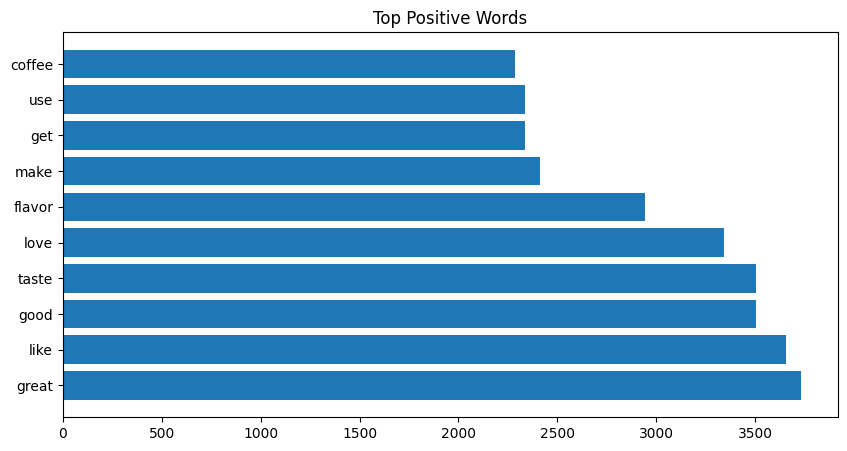

In [27]:
plt.figure(figsize=(10,5))
plot_top_ngrams(final_balanced_df[final_balanced_df['Sentiment']==1]['Cleaned_content'], "Top Positive Words",1)
plt.show()

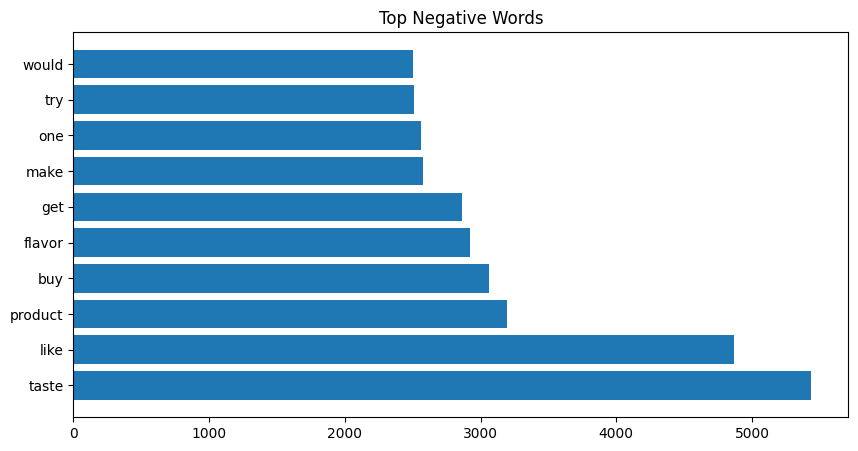

In [28]:
plt.figure(figsize=(10,5))
plot_top_ngrams(final_balanced_df[final_balanced_df['Sentiment']==0]['Cleaned_content'], "Top Negative Words",1)
plt.show()